In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

In [18]:
#Read in data 112K rows
data = pd.read_csv('Data_Entry_2017.csv')
data.drop('Unnamed: 11',axis=1, inplace=True)
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [19]:
#Add specific imagepath for correct diagnosis
images = {os.path.basename(x): x for x in 
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(images), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(images.get)
data.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
69900,00017233_003.png,No Finding,3,17233,61,F,PA,1847,2021,0.194311,0.194311,images_008/images/00017233_003.png
71484,00017618_000.png,Consolidation|Nodule,0,17618,35,M,PA,2992,2991,0.143000,0.143000,images_008/images/00017618_000.png
76092,00018669_001.png,Atelectasis|Effusion,1,18669,63,M,AP,3056,2544,0.139000,0.139000,images_009/images/00018669_001.png


In [20]:
data['Healthy'] = data['Finding Labels'].apply(lambda x:  np.where(x=='No Finding', 'Healthy', 'Sick'))

In [21]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.25,
                                    random_state=42)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [35]:
path_labels = list(data.Healthy.unique())
image_size = (128, 128)

train_gen = img_gen.flow_from_dataframe(dataframe=train_df, x_col = 'path',
y_col = 'Healthy', classes = path_labels, target_size = image_size, color_mode = 'grayscale',
batch_size = 32)

test_gen = img_gen.flow_from_dataframe(dataframe=test_df, x_col = 'path',
y_col = 'Healthy', classes = path_labels, target_size = image_size, color_mode = 'grayscale',
batch_size = 256)

test_X, test_Y = next(img_gen.flow_from_dataframe(dataframe=test_df,
x_col = 'path', y_col = 'Healthy', classes = path_labels,
target_size = image_size, color_mode = 'grayscale', 
                                                  batchsize = 1024))


Found 84090 validated image filenames belonging to 2 classes.
Found 28030 validated image filenames belonging to 2 classes.
Found 28030 validated image filenames belonging to 2 classes.


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_healthy_unflip_weights.best.hdf5".format('xray')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


model = Sequential()
model.add(Conv2D(128, (2, 2), input_shape=(128,128,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense((2)))
model.add(Activation('softmax'))

model.load_weights('xray_class_healthy_unflip_weights.best.hdf5')

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 128)     640       
_________________________________________________________________
activation (Activation)      (None, 127, 127, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       5

In [ ]:
model.fit(train_gen, 
                                  steps_per_epoch=train_df.shape[0]//32,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [ ]:
model.save('binary_model')

In [25]:
model=load_model('binary_model')

In [36]:
pred = model.predict(test_X).argmax(axis = 1)
true = test_Y.argmax(axis=1)

In [27]:
accuracy_score(true, pred)

0.75

In [28]:
precision_score(true, pred)

0.7333333333333333

In [30]:
recall_score(true, pred)


0.7333333333333333

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.jpg')
    plt.show()

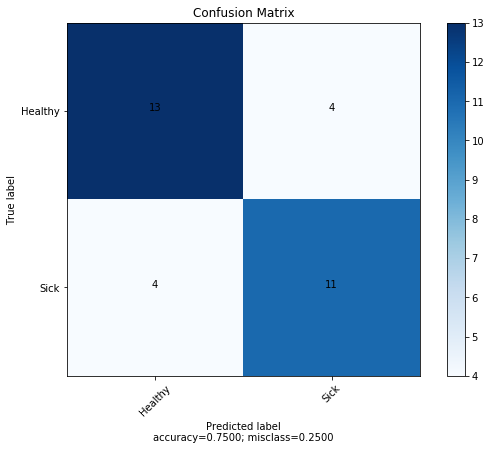

In [32]:
plot_confusion_matrix(cm = confusion_matrix(true,pred), 
                      normalize    = False,
                      target_names = ['Healthy', 'Sick'],
                      title        = "Confusion Matrix")
